/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_77181/2391057413.py:39: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_77181/2391057413.py:40: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_77181/2391057413.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((3, 3), (0, 2), colspan=1)
/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_77181/2391057413.py:

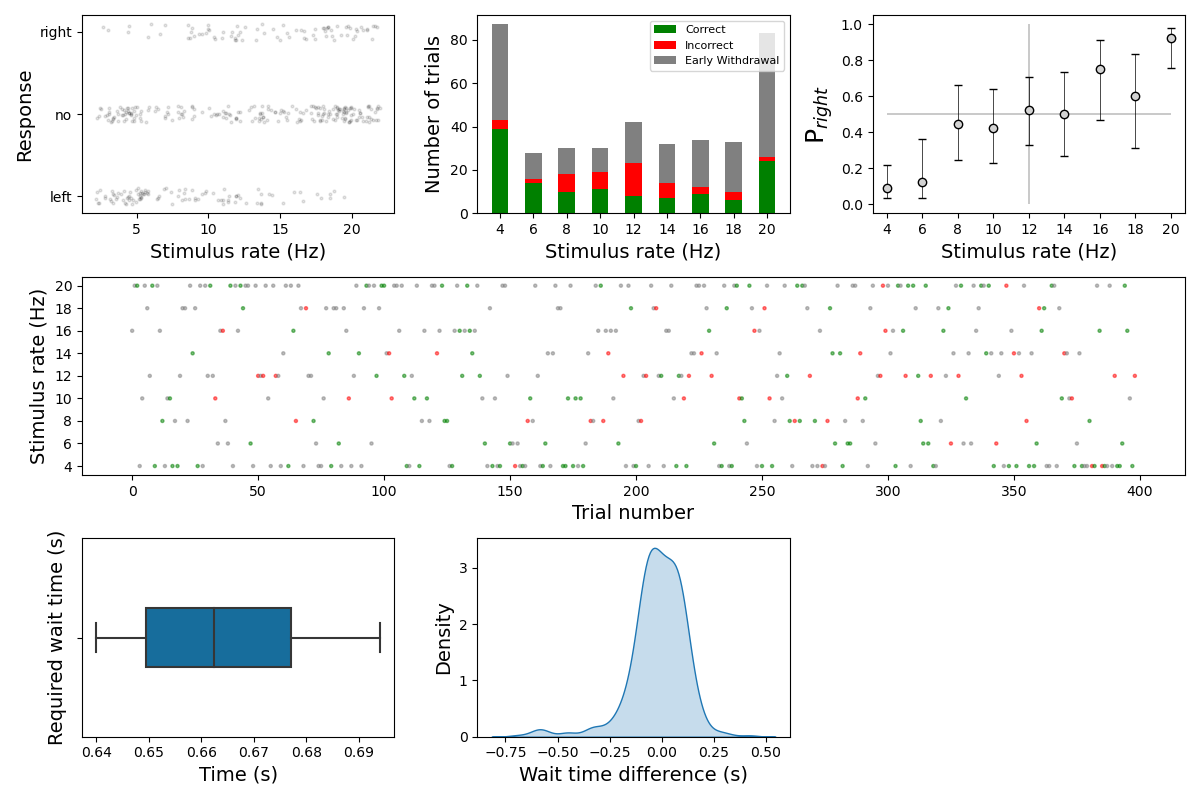

In [120]:
import numpy as np    # math and array handling 
import pandas as pd   # some functions to load data and handle tables
import pylab as plt   # plotting stuff
from glob import glob # to search files 
import seaborn as sns
import sys; sys.path.append('..') # this is not needed if you install the module
from chipmunk_performance_plots import *
%matplotlib widget

def performance_summary(filename):
    """
    Plots several behavioral measurements from a chipmunk session in a single figure. 

    Gabriel Rojas Bowe, Aug 2023.

    Adapted from code supplied by Joao Couto and Lukas Oesch.
    """
    # fn = pick_files("*.mat")
    # h5file = convert_specified_behavior_sessions(fn)
    # session_data = pd.read_hdf(h5file[0])
    session_data = pd.read_hdf(filename)

    ntrials = len(session_data)
    ntrials_with_choice = len(session_data[session_data['outcome_record'].isin([0, 1])])
    stim_rates = np.array([len(timestamps) for timestamps in session_data.stimulus_event_timestamps])
    unique_stim_rates = np.unique(stim_rates)

    response = []
    for r in session_data.response_side:
        if r == 0: #left choice
            response.append(-1)
        elif r == 1: #right choice
            response.append(r)
        else: #no choice/early withdrawal
            response.append(0)

    fig = plt.figure(1,figsize=(12, 8))

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1) 
    ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
    ax3 = plt.subplot2grid((3, 3), (0, 2), colspan=1)
    ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
    ax5 = plt.subplot2grid((3, 3), (2, 0), colspan=1)
    ax6 = plt.subplot2grid((3, 3), (2, 1), colspan=1)

    # First plot - response+noise per stimulus rate
    ax1.plot(stim_rates + np.random.uniform(-2, 2, len(session_data)),
             response + np.random.uniform(-0.1, 0.1, len(session_data)),
             'ko', alpha=0.1, markersize=2)
    
    ax1.set_ylabel('Response', fontsize=14)
    ax1.set_xlabel('Stimulus rate (Hz)', fontsize=14)
    ax1.set_yticks([-1, 0, 1], ['left', 'no', 'right'])

    # Second plot - response color-coded by outcome throughout the session
    c = []
    for i, (s, r) in enumerate(zip(np.array(stim_rates), np.array(response))):
        if ((s > 12) & (r > 0)) | ((s < 12) & (r < 0)):
            c.append('green')
        elif ((s == 12) & (session_data.outcome_record[i] == 1)):
            c.append('green')
        elif ((s == 12) & (session_data.outcome_record[i] == 0)):
            c.append('red')
        elif r == 0:
            c.append('grey')
        else:
            c.append('red')

    ax4.scatter(np.arange(len(stim_rates)), stim_rates, 5, c=c, alpha=0.5)
    ax4.set_ylabel('Stimulus rate (Hz)', fontsize=14)
    ax4.set_yticks([*unique_stim_rates])
    ax4.set_xlabel('Trial number', fontsize=14)

    # ax2.scatter([], [], 5, c='green', label='Correct', alpha=0.5)
    # ax2.scatter([], [], 5, c='red', label='Wrong', alpha=0.5)
    # ax2.scatter([], [], 5, c='grey', label='No response', alpha=0.5)
    # ax2.legend(loc='upper right', fontsize=8)


    # Third plot - histogram showing outcome record by trial type
    correct_responses = (session_data.outcome_record == 1)
    incorrect_responses = (session_data.outcome_record == 0)
    no_choice_responses = (session_data.outcome_record == -1)

    # Unique stim intensities
    correct = np.zeros_like(unique_stim_rates)
    incorrect = np.zeros_like(unique_stim_rates)
    no_choice = np.zeros_like(unique_stim_rates)
    # count the trials
    for i,rate in enumerate(unique_stim_rates):
        # print(i,rate)
        correct[i] = np.sum(correct_responses[np.array(stim_rates) == rate])
        incorrect[i] = np.sum(incorrect_responses[np.array(stim_rates) == rate])
        no_choice[i] = np.sum(no_choice_responses[np.array(stim_rates) == rate])

    # make a figure
    ax2.bar(unique_stim_rates,correct,width = 1,color = 'green', label='Correct')                # correct choices in BLACK
    ax2.bar(unique_stim_rates,incorrect,bottom = correct,width = 1,color='red', label='Incorrect') # incorrect choices in RED
    ax2.bar(unique_stim_rates,no_choice,bottom = correct+incorrect,width = 1,color='gray', label='Early Withdrawal') # no choice in GRAY
    ax2.set_xlabel('Stimulus rate (Hz)', fontsize = 14) # set the x-axis label
    ax2.set_ylabel('Number of trials', fontsize = 14) # set the y-axis label
    ax2.set_xticks([*unique_stim_rates])
    ax2.legend(loc='upper right', fontsize = 8)

    # Fourth plot - psychometric points + 95% CI
    sel = session_data[session_data.response_side.isin([0,1])] # select only trials where the subject responded
    responded_right = np.array(sel.response_side == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)   
    sel_stim_rates = np.array([len(timestamps) for timestamps in sel.stimulus_event_timestamps])

    # This is the function that does the actual computing, the rest is trial selection and plotting
    stims, p_side, ci_side, n_obs, n_side = compute_proportions(stim_values=sel_stim_rates, response_values=responded_right)

    ax3.vlines(12,0,1,color = 'k',lw = 0.3) # plot a vertical line as reference at zero
    ax3.hlines(0.5,np.min(stims),np.max(stims),color = 'k',lw = 0.3) # plot an horizontal line as reference for chance performance

    # plot the observed data and confidence intervals
    for i,e in zip(stims,ci_side):  # plot the confidence intervals
        ax3.plot(i*np.array([1,1]),e,'_-',lw=0.5,color = 'black')
    ax3.plot(stims,p_side,'ko',markerfacecolor = 'lightgray',markersize = 6)

    ax3.set_ylabel('P$_{right}$',fontsize = 18)  # set the y-axis label with latex nomenclature
    ax3.set_xlabel('Stimulus rate (Hz)', fontsize = 14); # set the x-axis label
    ax3.set_xticks([*unique_stim_rates])

    # Fifth plot - visualize required wait times
    wait_times = session_data.waitTime
    actual_wait_times = session_data.actual_wait_time

    wait_time_diff = []
    for array1, array2 in zip(wait_times, actual_wait_times):
        wait_time_diff.append(array2-array1)

    import seaborn as sns
    sns.boxplot(x=wait_times, palette='colorblind', width=0.3, ax=ax5)
    ax5.set_xlabel('Time (s)', fontsize = 14)
    ax5.set_ylabel('Required wait time (s)', fontsize = 14)
    
    # Sixth plot - kde of wait time differences
    sns.kdeplot(x=wait_time_diff, fill=True, palette='colorblind', ax=ax6)
    ax6.set_xlabel('Wait time difference (s)', fontsize = 14)
    ax6.set_ylabel('Density', fontsize = 14)

    fig.tight_layout()
    plt.show()

# performance_summary()
performance_summary('GRB004_20230331.h5')

In [4]:
import numpy as np    # math and array handling 
import pandas as pd   # some functions to load data and handle tables
import pylab as plt   # plotting stuff
from glob import glob # to search files 
import sys; sys.path.append('..') # this is not needed if you install the module
from chipmunk_performance_plots import *
%matplotlib widget

session_data = pd.read_hdf('GRB004_20230331.h5')